In [4]:
from keras.layers import Input, Reshape, Flatten, Activation
from keras.layers.merge import _Merge
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
from keras.utils import multi_gpu_model

import keras
import tensorflow as tf
import keras.backend as K
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from functools import partial
from itertools import zip_longest
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/pggan/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

gpu_count = 2

In [5]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)

In [6]:
class WGANGP():
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------
        self.resume = 0
        
        self.n_critic = 5
        self.λ = 10
        
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        # self.img_batch_shape = (batch_size, self.img_rows, self.img_cols, self.channels)
        self.input_rows = 4
        self.input_cols = 4
        self.latent_dim = 128  # Noiseの次元
        # optimizer = Adam(lr=0.00001, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        # optimizer = Adam(lr=0.00005, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        optimizer = Adam(lr=0.0001, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        # optimizer = Adam(lr=0.0005, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)

        # ---------------------
        #  Build model
        # ---------------------
        if self.resume == 0:
            self.critic = self.build_critic()
            self.generator = self.build_generator()
        else:
            self.critic = load_model('./saved_model/wgangp32_disc_model_'+str(self.resume)+'epoch.h5')
            self.generator = load_model('./saved_model/wgangp32_gen_model_'+str(self.resume)+'epoch.h5')

        #  Load pretrained weights
        pre_gen = load_model('./saved_model/wgangp16_gen_model.h5')
        for i, layer in enumerate(self.generator.layers[1].layers):
            if i in [i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]:
                layer.set_weights(pre_gen.layers[1].layers[i].get_weights())

        pre_critic = load_model('./saved_model/wgangp16_disc_model.h5')
        for i, layer in enumerate(self.critic.layers[1].layers):
            j = i - len(self.critic.layers[1].layers)
            if j in [-i for i in range(int(math.log(self.img_rows / self.input_rows, 2)) * 2, 0, -2)]:
                layer.set_weights(pre_critic.layers[1].layers[j].get_weights())
                layer.trainable = False

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------
        # Freeze generator's layers while training critic
        self.generator.trainable = False
     
        generator_input_for_discriminator = Input(shape=(self.latent_dim,))
        generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
        discriminator_output_from_generator = self.critic(generated_samples_for_discriminator)
        
        real_samples = Input(shape=self.img_shape)        
        discriminator_output_from_real_samples = self.critic(real_samples)

        averaged_samples = Input(shape=self.img_shape)
        averaged_samples_out = self.critic(averaged_samples)

        partial_gp_loss = partial(gradient_penalty_loss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[generator_input_for_discriminator, 
                                          real_samples,
                                          averaged_samples],
                                  outputs=[discriminator_output_from_generator, 
                                           discriminator_output_from_real_samples,
                                           averaged_samples_out])
        if gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=gpu_count)
        self.critic_model.compile(optimizer=optimizer, 
                                  loss=[wasserstein_loss, 
                                        wasserstein_loss, 
                                        partial_gp_loss])
        
        print('Critic Summary:')
        self.critic.summary()       
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True
        for i, layer in enumerate(self.generator.layers[1].layers):
            if i in [i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]:
                layer.trainable = False
                    
        generator_input = Input(shape=(self.latent_dim,))
        generator_layers = self.generator(generator_input)
        discriminator_layers_for_generator = self.critic(generator_layers)
        
        self.generator_model = Model(inputs=[generator_input], 
                                     outputs=[discriminator_layers_for_generator])
        if gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=gpu_count)
        self.generator_model.compile(optimizer=optimizer,
                                     loss=wasserstein_loss)        

        print('Genarator Summary:')
        self.generator.summary()   
   
    def build_generator(self):
        model = Sequential()
        model.add(Reshape((self.input_rows, self.input_cols, int(self.latent_dim / (self.input_rows * self.input_cols))), 
                          input_shape=(self.latent_dim,)
                         ))

        model.add(Conv2DTranspose(512, (3, 3), strides=1, padding='same',
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))      

        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2DTranspose(512, (3, 3), strides=2, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(256, (3, 3), strides=1, padding='same', 
                                  kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                  ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(32, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(16, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))                
        model.add(Activation("tanh"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_critic(self):
        model = Sequential()
        model.add(Conv2D(16, (1, 1), strides=1, input_shape=self.img_shape, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(32, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(64, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(128, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(256, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(512, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2D(512, (3, 3), strides=2, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(1, (4, 4), strides=1, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(Flatten())

        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size, sample_interval=50):
        # ---------------------
        #  Load the dataset
        # ---------------------      
        # Original dataset
        X_train = np.load('../datasets/lfw32.npz')['arr_0']
        X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1
        
        epsilon = np.random.uniform(size = (batch_size, 1,1,1))

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1), dtype=np.float32)
        fake = np.ones((batch_size, 1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)
        
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        for epoch in tqdm(range(self.resume, self.resume + epochs + 1)):
            for _ in range(self.n_critic):
                # ---------------------
                #  Train Critic
                # ---------------------
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                
                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                               
                # Mix real and genarate images
                mix_imgs = epsilon * imgs + (1-epsilon) * gen_imgs
                
                # Train the critic
                d_loss = self.critic_model.train_on_batch([noise, imgs, mix_imgs], 
                                                          [fake, valid, dummy])
                # d_loss = d_loss[0]
                
            # ---------------------
            #  Train Generator
            # ---------------------
            g_loss = self.generator_model.train_on_batch(noise, valid)
            
            # ---------------------
            #  Log on TensorBoard
            # ---------------------
            # Backup Model
            if epoch != 0 and epoch % 1000 == 0:
                self.critic.save('./saved_model/wgangp32_critic_model_'+str(epoch+self.resume)+'epoch.h5')
                self.generator.save('./saved_model/wgangp32_gen_model_'+str(epoch+self.resume)+'epoch.h5')
            
            # Save Loss & Histgram
            logs = {
                "loss/Critic": d_loss[0],
                "loss/Generator": g_loss,
                "loss_Critic/D_gen": d_loss[1],
                "loss_Critic/D_real": -d_loss[2],
                "loss_Critic/gradient_penalty": d_loss[3],
                "loss_Critic/total_loss": d_loss[1] + d_loss[2] + d_loss[3],                
            }

            histograms = {}
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch+self.resume)
            
            # Save generated image samples
            if epoch+self.resume == 1000 or epoch+self.resume == 2000 or (epoch+self.resume) % sample_interval == 0:
                fig, name = self.sample_images(epoch+self.resume)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch+self.resume)
                print("%d [C loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = ((0.5 * gen_imgs + 0.5) * 255).astype(np.uint8)
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        name = str(epoch) + ".png"
        return fig, name

In [7]:
wgan = WGANGP()

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Critic Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 8660001   
Total params: 8,660,001
Trainable params: 3,932,192
Non-trainable params: 4,727,809
_________________________________________________________________
Genarator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         8689059   
Total params: 8,689,059
Trainable params: 3,932,067
Non-trainable params: 4,756,992
_________________________________________________________________


  0%|          | 1/10001 [00:27<75:05:01, 27.03s/it]

0 [C loss: -4.600101] [G loss: 8.094321]


 10%|█         | 1001/10001 [43:43<7:11:12,  2.87s/it]

1000 [C loss: -6.749540] [G loss: 13.848776]


 11%|█         | 1115/10001 [48:40<6:23:56,  2.59s/it]

KeyboardInterrupt: 

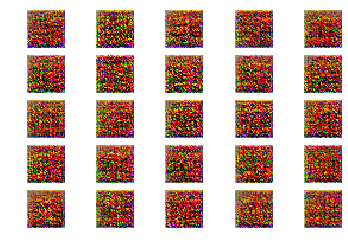

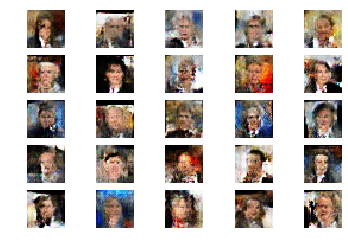

In [8]:
wgan.train(epochs=10000, batch_size=64, sample_interval=1000)

In [ ]:
gan.generator.save('./saved_model/wgangp32_gen_model.h5')
gan.critic.save('./saved_model/wgangp32_critic_model.h5')
# gan.combined.save('./saved_model/dcgan_wloss4_combined.h5')

In [5]:
noise = np.random.normal(0, 1, (128, wgan.latent_dim))

In [9]:
gen_imgs = wgan.generator.predict(noise)
print(gen_imgs.shape)

(128, 32, 32, 3)


In [13]:
gen_imgs = wgan.generator_model.predict(noise, batch_size=128)
print(gen_imgs.shape)

(128, 1)
